In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics
from sklearn.model_selection import KFold

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, ConcatDataset
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn
import torch.optim as optim
import datasets, custom_transforms, GusarevModel, pytorch_msssim

flag_debug = False
flag_load_previous_save = False
flag_selectFold, selectedFold = True, 5

# Input Directories
#data_BSE = "D:/data/JSRT/BSE_JSRT"
#data_normal = "D:/data/JSRT/JSRT"
data_BSE = Path('G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/trainValidate_LowRes/suppressed/')
data_normal = Path('G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/trainValidate_LowRes/normal/')
#data_val_normal = 'G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/validate/normal'
#data_val_BSE = 'G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/validate/suppressed/'

# Save directories:
output_save_directory = Path("./runs/6LayerCNN/177-20-20/Fold4_217perEpoch_400Epochs")
output_save_directory.mkdir(parents=True, exist_ok=True)
PATH_SAVE_NETWORK_INTERMEDIATE = os.path.join(output_save_directory, 'network_intermediate_{}.tar' )
PATH_SAVE_NETWORK_FINAL = os.path.join(output_save_directory, 'network_final_{}.pt')

# Image Size:
image_spatial_size = (256 , 256)
_batch_size = 5
split_k_folds=10
sample_keys_images = ["source", "boneless"]

# Optimisation
lr_ini = 0.001 
beta1 = 0.9
beta2 = 0.999

# Training
num_reals_per_epoch_paper = 217 #4000 # in Gusarev et al. 2017
total_num_epochs_paper = 400 # 150 in paper
num_epochs_decay_lr_paper = 100
lr_decay_ratio = 0.25

# Weight Initialisation
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0., 0.02)
        #nn.init.kaiming_normal_(m.weight.data,0)
        try:
            nn.init.constant_(m.bias.data, 0.)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.)

## Code for putting things on the GPU
ngpu = 1 #torch.cuda.device_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    if ngpu ==1:
        device=torch.device('cuda:0')

cuda
GeForce RTX 2080 Ti


In [2]:
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Data Loader
original_key = "source"
target_key = "boneless"
discriminator_keys_images = [original_key, target_key]
#ds_training = datasets.JSRT_CXR(data_normal, data_BSE,
#                         transform=tvtransforms.Compose([
                             # custom_transforms.HistogramEqualisation(discriminator_keys_images),-- check if training data is already equalised
#                             custom_transforms.Resize(discriminator_keys_images, image_spatial_size),
#                             custom_transforms.ToTensor(discriminator_keys_images),
#                             ])
#                      )
#ds_val = datasets.JSRT_CXR(data_val_normal, data_val_BSE,
#                         transform=tvtransforms.Compose([
                             #custom_transforms.HistogramEqualisation(discriminator_keys_images),#
#                             custom_transforms.Resize(discriminator_keys_images, image_spatial_size),
#                             custom_transforms.ToTensor(discriminator_keys_images),
#                             ])
#                      )

In [3]:
# Loss definitions

# Gusarev Loss
def criterion_MSELoss(testImage, referenceImage):
    mse = nn.MSELoss()
    mse_loss = mse(testImage, referenceImage)
    return mse_loss, mse_loss, torch.zeros(1)
def criterion_Gusarev(testImage, referenceImage, alpha=0.84):
    """
    Gusarev et al. 2017. Deep learning models for bone suppression in chest radiographs.  IEEE Conference on Computational Intelligence in Bioinformatics and Computational Biology.
    """
    mse = nn.MSELoss() # L2 used for easier optimisation c.f. L1
    mse_loss = mse(testImage, referenceImage)
    msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1, normalize='relu')
    msssim_loss = 1 - msssim(testImage, referenceImage)
    total_loss = (1-alpha)*mse_loss + alpha*msssim_loss
    return total_loss, mse_loss, msssim_loss

boneless
Fold 1
Skipping Fold
Fold 2
Skipping Fold
Fold 3
Skipping Fold
Fold 4
Skipping Fold
Fold 5
Using 6-Layer MultiCNN Model.
Epoch Factor: 1
Adjusting learning rate of group 0 to 1.0000e-03.
FLAG: NO CHECKPOINT LOADED.
0.001
[0/400][0/36]	Total Loss: 0.8613	MSELoss: 0.1333	MSSSIM Loss: 1.0000
[0/400][1/36]	Total Loss: 0.3538	MSELoss: 0.0660	MSSSIM Loss: 0.4087
[0/400][2/36]	Total Loss: 0.4575	MSELoss: 0.1357	MSSSIM Loss: 0.5188
[0/400][3/36]	Total Loss: 0.2849	MSELoss: 0.0408	MSSSIM Loss: 0.3313
[0/400][4/36]	Total Loss: 0.1216	MSELoss: 0.0206	MSSSIM Loss: 0.1408
[0/400][5/36]	Total Loss: 0.1479	MSELoss: 0.0152	MSSSIM Loss: 0.1732
[0/400][6/36]	Total Loss: 0.0683	MSELoss: 0.0044	MSSSIM Loss: 0.0805
[0/400][7/36]	Total Loss: 0.1146	MSELoss: 0.0197	MSSSIM Loss: 0.1327
[0/400][8/36]	Total Loss: 0.0976	MSELoss: 0.0084	MSSSIM Loss: 0.1145
[0/400][9/36]	Total Loss: 0.0647	MSELoss: 0.0051	MSSSIM Loss: 0.0760
[0/400][10/36]	Total Loss: 0.0763	MSELoss: 0.0172	MSSSIM Loss: 0.0876
[0/400][11

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learni

Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.0005625000000000001
Adjusting learning rate of group 0 to 5.6250e-04.
0.000562500000

Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjusting learning rate of group 0 to 4.2187e-04.
0.000421875
Adjustin

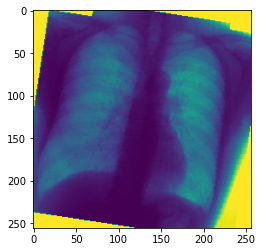

In [4]:
# Training

# Data augmentation transformations
data_transforms = {
    'train_transforms': tvtransforms.Compose([
    custom_transforms.RandomAutocontrast(sample_keys_images, cutoff_limits=(0.1,0.1)),
    custom_transforms.CenterCrop(sample_keys_images,256),
    custom_transforms.RandomHorizontalFlip(sample_keys_images, 0.5),
    custom_transforms.RandomAffine(sample_keys_images, degrees=10,translate=(0.1,0.1),scale=(0.9,1.1)),
    custom_transforms.ToTensor(sample_keys_images),
    custom_transforms.ImageComplement(sample_keys_images),
    ])
      ,
    'test_transforms': tvtransforms.Compose([
      custom_transforms.ToTensor(sample_keys_images),
    ]),
    }

# K-FOLD VALIDATION
#dataset = ConcatDataset([ds_training, ds_val])
splits=KFold(n_splits=split_k_folds,shuffle=True,random_state=42)
foldperf={}

print(target_key)
dataset = datasets.JSRT_CXR(data_normal, data_BSE, transform=None)
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    # fold starts from 0
    print('Fold {}'.format(fold + 1))
    if flag_selectFold and selectedFold >= 1 and selectedFold <= split_k_folds:
        if fold + 1 != selectedFold:
            print("Skipping Fold")
            continue
    
    history = {'loss':[], 'ssim_acc':[]}
    
    # Subset sample from dataset
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    dl_training = DataLoader(datasets.JSRT_CXR(data_normal, data_BSE, transform=data_transforms['train_transforms']),
                             batch_size=_batch_size, sampler=train_sampler, num_workers=0)
    dl_validation = DataLoader(datasets.JSRT_CXR(data_normal, data_BSE, transform=data_transforms['train_transforms']),
                             batch_size=_batch_size, sampler=test_sampler, num_workers=0)
    
    # Print example of transformed image
    for count, sample in enumerate(dl_training):
        image = sample["source"][0,:]
        image = torch.squeeze(image)
        plt.imshow(image)
        if count == 0:
            break
    
    # Network
    input_array_size = (_batch_size, 1, image_spatial_size[0], image_spatial_size[1])
    net = GusarevModel.MultilayerCNN(input_array_size)
    # Initialise weights
    net.apply(weights_init)

    # Multi-GPU
    if (device.type == 'cuda') and (ngpu > 1):
        print("Neural Net on GPU")
        net = nn.DataParallel(net, list(range(ngpu)))
    net = net.to(device)

    # Optimiser
    optimizer = torch.optim.Adam(net.parameters(), lr=lr_ini, betas=(beta1, beta2))

    # Learning Rate Scheduler
    epoch_factor = round(num_reals_per_epoch_paper/len(train_idx)) # need to have this factor as many epochs as that described in the paper
    print("Epoch Factor: "+str(epoch_factor))
    total_num_epochs = int(total_num_epochs_paper*epoch_factor)
    num_epochs_decay_lr = int(num_epochs_decay_lr_paper*epoch_factor)
    lambda_rule = lambda epoch: 1*((1-lr_decay_ratio)**(epoch//num_epochs_decay_lr))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule, verbose=True)
    
    # For each epoch
    epochs_list = []
    img_list = []
    training_loss_list = []
    reals_shown = []
    #validation_loss_per_epoch_list = []
    #training_loss_per_epoch_list = []
    loss_per_epoch={"training":[], "validation":[]}
    ssim_average={"training":[], "validation":[]}

    
    
    #fixed_val_sample = next(iter(dl_validation))
    #fig, ax = plt.subplots(1,2)
    #ax[0].imshow(fixed_val_sample[original_key][0,0,:])
    #ax[1].imshow(fixed_val_sample[target_key][0,0,:])
    #plt.show()
    
    # optionally resume from a checkpoint
    if flag_load_previous_save:
        if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
            print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
            checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE)
            start_epoch = checkpoint['epoch_next']
            reals_shown_now = checkpoint['reals_shown']
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            net.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                                start_epoch, reals_shown_now))
            print(scheduler)
        else:
            print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
            raise RuntimeError("No checkpoint found at specified path.")
    else:
        print("FLAG: NO CHECKPOINT LOADED.")
        reals_shown_now = 0
        start_epoch=0

    # Loop variables
    flag_break = False # when debugging, this will automatically go to True
    iters = 0
    net.train()
    for param in net.parameters():
        param.requires_grad = True
    for epoch in range(start_epoch, total_num_epochs):
        print(optimizer.param_groups[0]['lr'])
        sum_loss_in_epoch = 0
        for i, data in enumerate(dl_training):
            # Training
            net.zero_grad()
            noisy_data = data[original_key].to(device)
            cleaned_data = net(noisy_data)
            loss, maeloss, msssim_loss = criterion_Gusarev(cleaned_data, data[target_key].to(device))
            loss.backward() # calculate gradients
            optimizer.step() # optimiser step along gradients

            # Output training stats
            if epoch%1000 == 0:
                print('[%d/%d][%d/%d]\tTotal Loss: %.4f\tMSELoss: %.4f\tMSSSIM Loss: %.4f'
                      % (epoch, total_num_epochs, i, len(dl_training),
                         loss.item(), maeloss.item(), msssim_loss.item()))
            # Record generator output
            #if reals_shown_now%(100*_batch_size)==0:
            #    with torch.no_grad():
            #        val_cleaned = net(fixed_val_sample["source"].to(device)).detach().cpu()
            #    print("Printing to img_list")
            #    img_list.append(vutils.make_grid(val_cleaned[0:1,0:1,:], padding=2, normalize=True))
            #iters +=1
            #if flag_debug and iters>=10:
            #    flag_break = True
            #    break

            # Running counter of reals shown
            reals_shown_now += _batch_size
            reals_shown.append(reals_shown_now)

            # Training loss list for loss per minibatch
            training_loss_list.append(loss.item()) # training loss
            sum_loss_in_epoch += loss.item()*len(cleaned_data)
        # Turn the sum loss in epoch into a loss-per-epoch
        loss_per_epoch["training"].append(sum_loss_in_epoch/len(train_idx))


        with torch.no_grad():
            # Training Accuracy per EPOCH
            ssim_training_list = []
            for train_count, data in enumerate(dl_training):
                noisy_training_data = data[original_key].to(device)
                true_training_data = data[target_key]
                cleaned_training_data = net(noisy_training_data)

                for ii, image in enumerate(cleaned_training_data):
                    clean_training_numpy = image.cpu().detach().numpy()
                    true_training_numpy = true_training_data[ii].numpy()
                    clean_training_numpy = np.moveaxis(clean_training_numpy, 0, -1)
                    true_training_numpy = np.moveaxis(true_training_numpy, 0, -1)
                    ssim_training = skimage.metrics.structural_similarity(clean_training_numpy, true_training_numpy, multichannel=True)
                    ssim_training_list.append(ssim_training) # SSIM per image
            ssim_average["training"].append(np.mean(ssim_training_list))

            # Validation Loss and Accuracy per EPOCH
            sum_loss_in_epoch =0
            ssim_val_list = []
            for val_count, sample in enumerate(dl_validation):
                noisy_val_data = sample[original_key].to(device)
                cleaned_val_data = net(noisy_val_data)

                # Loss
                true_val_data = sample[target_key]
                val_loss, maeloss, msssim_loss = criterion_Gusarev(cleaned_val_data, true_val_data.to(device))
                sum_loss_in_epoch += val_loss.item()*len(cleaned_val_data)

                # Accuracy
                for ii, image in enumerate(cleaned_val_data):
                    clean_val_numpy = image.cpu().detach().numpy()
                    true_val_numpy = true_val_data[ii].numpy()
                    clean_val_numpy = np.moveaxis(clean_val_numpy, 0, -1)
                    true_val_numpy = np.moveaxis(true_val_numpy, 0, -1)
                    ssim_val = skimage.metrics.structural_similarity(clean_val_numpy, true_val_numpy, multichannel=True)
                    ssim_val_list.append(ssim_val) # SSIM per image
            # After considering all validation images
            loss_per_epoch["validation"].append(sum_loss_in_epoch/len(val_idx))
            ssim_average["validation"].append(np.mean(ssim_val_list))
        epochs_list.append(epoch)
        # LR Scheduler after epoch
        scheduler.step()
        
        #if epoch % 5 == 0:
        #    if not flag_debug:
        #        #torch.save(net.state_dict(), PATH_SAVE_NETWORK_INTERMEDIATE)
        #        torch.save({
        #        'epochs_completed': epoch+1,
        #        'epoch_next': epoch+1,
        #        'model_state_dict': net.state_dict(),
        #        'optimizer_state_dict': optimizer.state_dict(),
        #        'loss': loss,
        #        'scheduler_state_dict': scheduler.state_dict(),
        #        'reals_shown': reals_shown_now
        #        }, PATH_SAVE_NETWORK_INTERMEDIATE.format(fold))
        #        print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE.format(fold))
        #if flag_break:
        #    break
        
    #After all epochs, save results:
    history["loss"] = loss_per_epoch
    history["ssim_acc"] = ssim_average
    
    foldperf['fold{}'.format(fold+1)] = history
    
    # Final Save for each fold
    if not flag_debug:
        torch.save({
                'epochs_completed': epoch+1,
                'epoch_factor': epoch_factor,
                'total_num_epochs': total_num_epochs,
                'total_num_epochs_paper': total_num_epochs_paper,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'scheduler_state_dict': scheduler.state_dict(),
                'reals_shown': reals_shown_now
                }, PATH_SAVE_NETWORK_INTERMEDIATE.format(fold))
        print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE.format(fold)))
    

In [5]:
if not flag_debug and not flag_selectFold:
    torch.save({
            'epochs_completed': epoch+1,
            'epoch_factor': epoch_factor,
            'total_num_epochs': total_num_epochs,
            'total_num_epochs_paper': total_num_epochs_paper,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler_state_dict': scheduler.state_dict(),
            'reals_shown': reals_shown_now
            }, PATH_SAVE_NETWORK_INTERMEDIATE.format(fold))
    print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE.format(fold)))

Training complete
Performance of 10 fold cross validation
Average Training Loss: 0.016 	 Average Test Loss: 0.015 	 Average Training Acc: 0.962 	 Average Test Acc: 0.964
Best fold: 1


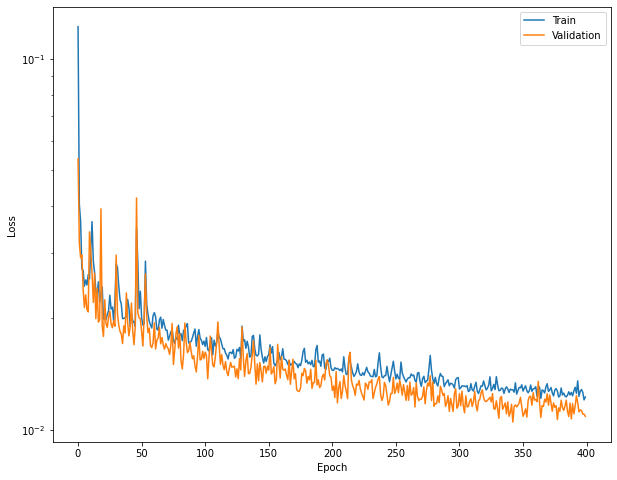

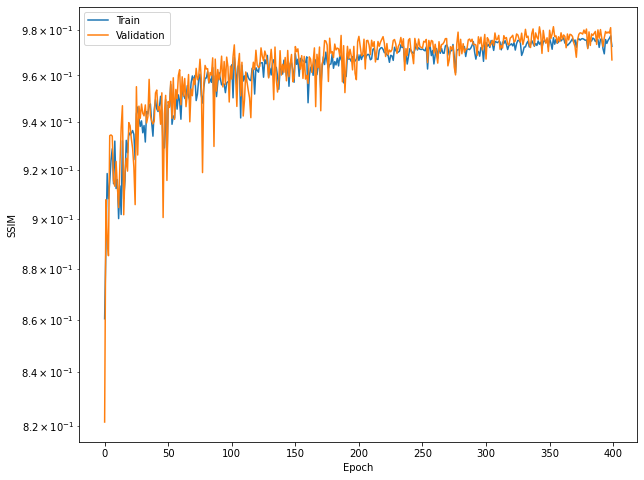

In [6]:
print("Training complete")
# Find the best fold


# AVERAGE PERFORMANCE
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=10
if flag_selectFold:
    initial_fold=selectedFold
else:
    initial_fold=1
fold_range = range(initial_fold, initial_fold+len(foldperf.keys()))
for f in fold_range:
    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['loss']['training']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['loss']['validation']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['ssim_acc']['training']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['ssim_acc']['validation']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}"
      .format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))
print("Best fold: {}".format(np.argmax(testa_f) + 1))

# Averaging accuracy and loss
diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}
for i in range(total_num_epochs):
    diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f)]['loss']['training'][i] for f in fold_range]))
    diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f)]['loss']['validation'][i] for f in fold_range]))
    diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f)]['ssim_acc']['training'][i] for f in fold_range]))
    diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f)]['ssim_acc']['validation'][i] for f in fold_range]))

# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['test_loss_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_loss"+".png"))
plt.show()

# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['test_acc_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
#plt.grid()
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_accuracy"+".png"))
plt.show()

NameError: name 'fixed_val_sample' is not defined

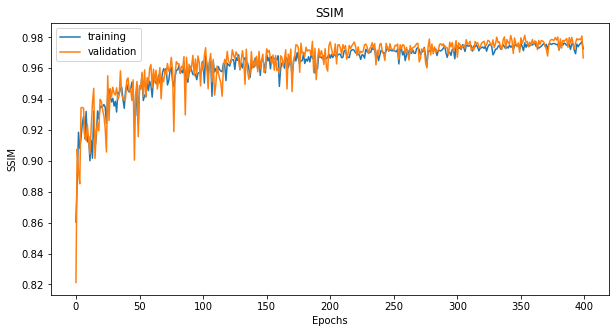

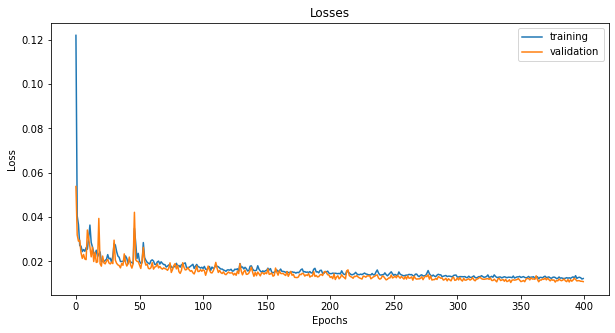

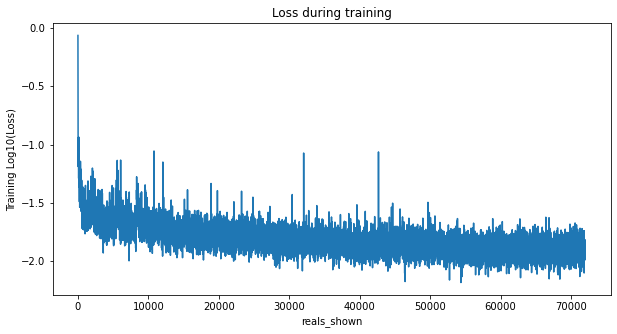

In [7]:
%matplotlib inline 
import math
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Accuracy
plt.figure(figsize=(10,5))
plt.title("SSIM")
plt.plot(epochs_list, ssim_average["training"], label='training')
plt.plot(epochs_list, ssim_average["validation"] , label='validation')
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.legend()
#if not flag_debug:
#    plt.savefig(os.path.join(output_save_directory, current_date + "_accuracy"+".png"))
    
# All losses
plt.figure(figsize=(10,5))
plt.title("Losses")
plt.plot(epochs_list, loss_per_epoch["training"], label='training')
plt.plot(epochs_list, loss_per_epoch["validation"] , label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
#if not flag_debug:
#    plt.savefig(os.path.join(output_save_directory, current_date + "_loss"+".png"))

# Loss for training
plt.figure(figsize=(10,5))
plt.title("Loss during training")
plt.plot(reals_shown, [math.log10(y) for y in training_loss_list])
plt.xlabel("reals_shown")
plt.ylabel("Training Log10(Loss)")
#if not flag_debug:
#    plt.savefig(os.path.join(output_save_directory, current_date + "_training_loss"+".png"))


    
# Final Model:
with torch.no_grad():
    input_image = fixed_val_sample['source']
    input_images = vutils.make_grid(input_image[0:1,:,:,:], padding=2, normalize=True)
    target_images = vutils.make_grid(fixed_val_sample['boneless'][0:1,:,:,:], padding=2, normalize=True)
    net = net.cpu()
    output_image = net(input_image[0:1,:,:,:]).detach().cpu()
    output_images = vutils.make_grid(output_image, padding=2, normalize=True)
#print(str(torch.max(output_images)) + "," + str(torch.min(output_images)))
plt.figure(1)
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(np.transpose(input_images, (1,2,0)), vmin=0, vmax=1)
ax[0].set_title("Source")
ax[0].axis("off")
ax[1].imshow(np.transpose(output_images, (1,2,0)), vmin=0, vmax=1)
ax[1].set_title("Suppressed")
ax[1].axis("off")
ax[2].imshow(np.transpose(target_images, (1,2,0)), vmin=0, vmax=1)
ax[2].set_title("Ideal Bone-suppressed")
ax[2].axis("off")
plt.show
#if not flag_debug:
#    plt.savefig(os.path.join(output_save_directory, current_date + "_validation_ComparisonImages"+".png"))

# ANIMATED VALIDATION IMAGE
#fig = plt.figure(figsize=(8,8))
#ax = fig.add_subplot(111)
#plt.axis("off")
#ims = []
#training_ims_shown = []
#for i, im in enumerate(img_list):
#    if i % 50 == 0:  # controls how many images are printed into the animation
#        training_ims_shown = i*(100*_batch_size)
#        frame = ax.imshow(np.transpose(im,(1,2,0)))
#        t = ax.annotate("Reals shown: {}".format(training_ims_shown), (0.5,1.02), xycoords="axes fraction")
#        ims.append([frame, t])
#ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
#if not flag_debug:
#    ani.save(os.path.join(output_save_directory, current_date+"_animation.mp4"), dpi=300)